## This is exact same version of Final Image Classificaiton notebook.

Except this does not use weighted classes

In [1]:
import os, sys, re, string, pathlib, random, io, time, glob
from collections import Counter, OrderedDict
from shutil import copyfile, rmtree

#import hecutils.resnet152 as resnet
from hecutils.resnet152 import ResNet152

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import hecutils.data_utils as dt
import hecutils.scoring_utils as sc
import hecutils.plotting_utils as pt
import hecutils.image_utils as imut
import hecutils.caption_utils as caput



import tensorflow as tf
from keras import backend as K
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras.layers import GRU, Bidirectional, LSTM, MaxPooling1D, Conv1D,Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers.core import Dropout, Flatten, Masking, ActivityRegularization
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import text
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Model
from keras import optimizers

# from fastText import load_model
from gensim.models import word2vec
from gensim.models.keyedvectors import KeyedVectors


import numpy as np
import pandas as pd
from sklearn.utils import shuffle, class_weight
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix

from os import listdir
from os.path import isfile, join


%matplotlib inline 

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


None


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
from keras import backend as K

num_cores = 8
GPU=True
CPU = not GPU

if GPU:
    num_GPU = 1
    num_CPU = 8
if CPU:
    num_CPU = 8
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

In [3]:
oasis_csv_path = "dataset/metadata/OASIS.csv"
oasis_images_src = "dataset/images/"
input_images_src = "dataset/input2/"
test_images_src = "dataset/test2/"
model_results_root_dir = "img_model2/"

input_images_classified = "dataset/input-classified2/"
test_images_classified = "dataset/test-classified2/"

# ou can downlaod weights here: https://gist.github.com/flyyufelix/7e2eafb149f72f4d38dd661882c554a6
weights_path = "/home/elkhand/weights/resnet152_weights_tf.h5"

dataset_groups=["train", "val"]
classes = ["negative", "neutral", "positive"]

# fix random seed for reproducibility
seed = 7

test_size = 0.1

kfold_splits = 5 

neutralLow = 3.0
neutralHigh = 5.0

nb_epochs =  100
patience = 10 
batch_size = 32

FC_SIZE = 1024 
LAYERS_TO_UNFREEZE = 10

img_height = 224 # 299
img_width = 224  # 299

useF1Score = True
verbose=1 


oasis_csv_path = "dataset/metadata/OASIS.csv"
captions_root = "/home/elkhand/git-repos/human-emotions-classifier/dataset/metadata"
captions_root_path = pathlib.Path(captions_root)
human_output_caption_to_label_csv_path = captions_root_path/'humanCaptionWithLabeldf.csv'
human_caption_csv_path = captions_root_path/'captions.csv'
#fasttext_embedding_path = 'embedding/wiki-news-300d-1M.vec'
fasttext_embedding_path = '/home/elkhand/datasets/glove-vectors/glove.twitter.27B.200d.txt'
#model_results_root_dir = "model/"
inputDataset_csv_path = captions_root_path/"inputDataset.csv"
testDataset_csv_path = captions_root_path/"testDataset.csv"
dataset_path = human_output_caption_to_label_csv_path
# dataset_path = auto_output_caption_to_label_csv_path

## Original way of splitting data into train/dev/test splits

In [4]:
# image_names, image_labels = dt.get_image_name_and_label(oasis_csv_path, neutralLow, neutralHigh)
# imageNameToImageId = dt.get_image_title_to_image_id(oasis_csv_path)

# for i in range(5):
#     imageName = image_names[i]
#     imageName = imageName.split(".")[0]
#     print(imageNameToImageId[imageName], image_labels[i])
    
# print("\n")

# for i in range(-5,0,1):
#     imageName = image_names[i]
#     imageName = imageName.split(".")[0]
#     print(imageNameToImageId[imageName], image_labels[i])    
# print("\n")
    
# imageNameToLabel = {}

# for img_name,label in zip(image_names, image_labels):
#     if img_name not in imageNameToLabel:
#         imageNameToLabel[img_name] = label
#     else:
#         raise "There should not be images with same name: " + img_name + label    
        
# image_names = np.array(image_names)
# image_labels = np.array(image_labels)

# input_x, test_x, input_y,  test_y = train_test_split(image_names, image_labels,
#                                                     test_size=test_size,
#                                                     random_state=seed,
#                                                     stratify=image_labels)

# print("Input data (to be used for model learning and validation) label distribution: \n",pt.get_label_count(input_y))
# print()
# print("Test data(never used for learning) label distribution: \n",pt.get_label_count(test_y))


# # Delete input images dir
# rmtree(input_images_src, ignore_errors=True)
# os.makedirs(input_images_src)


# # Delete test images dir
# rmtree(test_images_src, ignore_errors=True)
# os.makedirs(test_images_src)


# # Copy input images into input dir, and test images into test dir
# imut.copy_imgs_into(oasis_images_src, input_x, input_images_src)
# imut.copy_imgs_into(oasis_images_src, test_x, test_images_src)



## Common way of separating data into input and test

### Divide data into train/val/test datasets

Read dataframe to have:

<imageName, caption, label>

1. Read into df <imageId, label>
2. Then separate data into input and test datasets

In [5]:
dfImageIdCaptionLabel = pd.read_csv(dataset_path, header=0, sep="|")
dfImageIdCaptionLabel.columns = ["id","caption", "label"]
dfImageIdCaptionLabel["caption"] = dfImageIdCaptionLabel["caption"].apply(lambda x: " ".join(caput.get_words_withoutstopwords(x.lower().split())))
#dfImageIdCaptionLabel["label"] = dfImageIdCaptionLabel["label"].apply(lambda x: caput.change_label_str_to_int(x))


dfImageIdImageName = dt.get_image_id_to_image_title_as_df(oasis_csv_path)
dfImageIdImageName.columns = ['id', 'image_name']
dfImageIdImageName['image_name'] = dfImageIdImageName['image_name'].apply(lambda x: x + ".jpg") 
printCnt = 5
# has [id, caption, label]
df = pd.merge(dfImageIdCaptionLabel, dfImageIdImageName, on="id")
df["label"] = df["label"].apply(lambda x: caput.change_label_str_to_int(x))
#print(df.head(printCnt))

imageNameToLabel = {}

for index, row in df.iterrows():
    img_name = row['image_name']
    label = row['label']
    imageNameToLabel[img_name] = label


input_x, test_x, input_y,  test_y = train_test_split(df["id"],
                                                     df["label"],
                                                     test_size=test_size,
                                                     random_state=seed,
                                                     stratify=df["label"])

inputDataset = pd.concat([input_x, input_y], axis=1)
testDataset = pd.concat([test_x, test_y], axis=1)



# print("inputDataset\n", inputDataset.head(10))
# print("testDataset\n", testDataset.head(10))

print("\n")
print("Label distribution in inputDataset", inputDataset.groupby('label').label.count())
print("Label distribution in testDataset", testDataset.groupby('label').label.count())


inputDataset = df.loc[df['id'].isin(inputDataset.id)]
testDataset = df.loc[df['id'].isin(testDataset.id)]

inputDataset = inputDataset.dropna()
testDataset = testDataset.dropna()
inputDataset = inputDataset.reset_index()
testDataset = testDataset.reset_index()

# print("inputData\n", inputData.head())
# print("testData\n", testData.head())

inputIds = set(inputDataset['id'].values)
testIds = set(testDataset['id'].values)

print("Input data size", len(inputIds))
print("Test data size", len(testIds))

for inputId in inputIds:
    if inputId in testIds:
        raise inputId + " inputId exists both in test and input dataset"
        
for testId in testIds:
    if testId in inputIds:
        raise testId + " testId exists both in test and input dataset"        

inputDataset.head()



Label distribution in inputDataset label
-1    147
 0    378
 1    285
Name: label, dtype: int64
Label distribution in testDataset label
-1    16
 0    42
 1    32
Name: label, dtype: int64
Input data size 810
Test data size 90


,index,id,caption,label,image_name
0,0,I1,two acorns lying ground next oak leaves.,0,Acorns 1.jpg
1,2,I100,ruined walls church backdrop white clouds blue...,0,Building 2.jpg
2,3,I101,man free fall attached blue bungee jumping app...,0,Bungee jumping 1.jpg
3,4,I102,falling man attached bungee jumping apparatus....,0,Bungee jumping 2.jpg
4,6,I104,man kneeling front tent two similar-looking gi...,1,Camping 1.jpg


## Creating test and input dataset, and `positive,neutral,negative` under each dataset

In [6]:
# Delete input images dir
rmtree(input_images_src, ignore_errors=True)
os.makedirs(input_images_src)


# Delete test images dir
rmtree(test_images_src, ignore_errors=True)
os.makedirs(test_images_src)


# Copy input images into input dir, and test images into test dir
imut.copy_imgs_into(oasis_images_src, inputDataset['image_name'], input_images_src)
imut.copy_imgs_into(oasis_images_src, testDataset['image_name'], test_images_src)


test_x, test_y = testDataset['image_name'], testDataset['label']

X = inputDataset['image_name']
y = inputDataset['label']

# Divide input images into train and dev set, and each one into {negative, neutral, positive}
#isForTest = False
#X_train = inputDataset['image_name']
#y_train = inputDataset['label']
#dt.create_dataset("train", input_images_src, input_images_classified, X_train, y_train, isForTest)
#X_val = inputData['image_name'] # TODO COrrect
#y_val = inputData['label']
#dt.create_dataset("val", input_images_src, input_images_classified, X_val, y_val, isForTest)

config:
 {'img_height': 224, 'img_width': 224, 'kfold_splits': 5, 'batch_size': 32, 'nb_epochs': 100, 'useF1Score': True, 'verbose': 1}
train_indices[:5] [0 1 2 3 4] train_indices[-5:] [804 805 806 807 808]
val_indices[:5] [ 6 14 17 19 21] val_indices[-5:] [769 782 802 803 809]

Train size:  647
Val size:  163
Train label distribution:  OrderedDict([(-1, 108), (0, 307), (1, 232)])
Val label distribution:  OrderedDict([(-1, 39), (0, 71), (1, 53)])
Found 647 images belonging to 3 classes.
Found 163 images belonging to 3 classes.


/home/elkhand/anaconda3/envs/cs231n/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`



Epoch 1/3
62/62 [==============================] - 28s 447ms/step - loss: 2.4619 - acc: 0.4653 - f1: 0.4613 - recall: 0.4525 - precision: 0.4708 - val_loss: 0.9409 - val_acc: 0.5375 - val_f1: 0.5072 - val_recall: 0.4562 - val_precision: 0.5751
Epoch 2/3
62/62 [==============================] - 26s 412ms/step - loss: 1.2058 - acc: 0.5363 - f1: 0.5221 - recall: 0.5010 - precision: 0.5467 - val_loss: 0.8416 - val_acc: 0.5625 - val_f1: 0.5383 - val_recall: 0.5125 - val_precision: 0.5673
Epoch 3/3
62/62 [==============================] - 25s 403ms/step - loss: 1.0041 - acc: 0.5873 - f1: 0.5785 - recall: 0.5527 - precision: 0.6094 - val_loss: 0.8512 - val_acc: 0.6125 - val_f1: 0.5658 - val_recall: 0.5125 - val_precision: 0.6343
Starting fune-tuning
LAYERS_TO_UNFREEZE: 10 last layer id to freeze 716 total layers,  726
Epoch 1/100
62/62 [==============================] - 28s 445ms/step - loss: 0.9966 - acc: 0.5962 - f1: 0.5878 - recall: 0.5669 - precision: 0.6110 - val_loss: 1.0207 - val_acc:

Epoch 28/100
62/62 [==============================] - 24s 391ms/step - loss: 0.5138 - acc: 0.7821 - f1: 0.7682 - recall: 0.7372 - precision: 0.8038 - val_loss: 0.7693 - val_acc: 0.6750 - val_f1: 0.6303 - val_recall: 0.5813 - val_precision: 0.6946
Epoch 29/100
62/62 [==============================] - 24s 386ms/step - loss: 0.4932 - acc: 0.7952 - f1: 0.7897 - recall: 0.7569 - precision: 0.8270 - val_loss: 0.7689 - val_acc: 0.6750 - val_f1: 0.6409 - val_recall: 0.5938 - val_precision: 0.7032

Epoch 00029: ReduceLROnPlateau reducing learning rate to 2.8247522277524694e-05.
Epoch 30/100
62/62 [==============================] - 24s 391ms/step - loss: 0.5088 - acc: 0.7877 - f1: 0.7792 - recall: 0.7479 - precision: 0.8146 - val_loss: 0.7713 - val_acc: 0.6687 - val_f1: 0.6388 - val_recall: 0.5938 - val_precision: 0.6987
Epoch 31/100
62/62 [==============================] - 24s 385ms/step - loss: 0.5126 - acc: 0.7849 - f1: 0.7790 - recall: 0.7480 - precision: 0.8147 - val_loss: 0.7681 - val_acc:

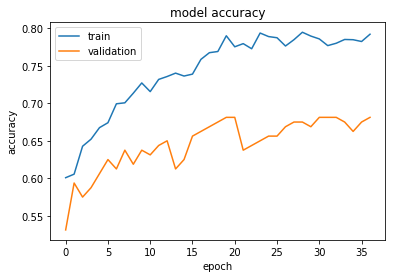

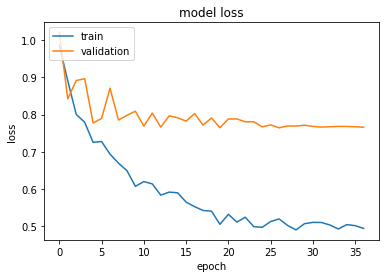

best_val_acc 0.68125
train_indices[:5] [2 4 5 6 7] train_indices[-5:] [802 803 805 807 809]
val_indices[:5] [ 0  1  3  9 10] val_indices[-5:] [791 798 804 806 808]

Train size:  647
Val size:  163
Train label distribution:  OrderedDict([(-1, 117), (0, 307), (1, 223)])
Val label distribution:  OrderedDict([(-1, 30), (0, 71), (1, 62)])
Found 647 images belonging to 3 classes.
Found 163 images belonging to 3 classes.

Epoch 1/3
62/62 [==============================] - 28s 451ms/step - loss: 4.0363 - acc: 0.4820 - f1: 0.4820 - recall: 0.4805 - precision: 0.4837 - val_loss: 1.1147 - val_acc: 0.4875 - val_f1: 0.4799 - val_recall: 0.4375 - val_precision: 0.5321
Epoch 2/3
62/62 [==============================] - 25s 403ms/step - loss: 1.3315 - acc: 0.5324 - f1: 0.5225 - recall: 0.5049 - precision: 0.5421 - val_loss: 0.9656 - val_acc: 0.5125 - val_f1: 0.5221 - val_recall: 0.5062 - val_precision: 0.5396
Epoch 3/3
62/62 [==============================] - 25s 400ms/step - loss: 1.0664 - acc: 0.573


Epoch 00026: ReduceLROnPlateau reducing learning rate to 5.76480058953166e-05.
best_train_acc 0.7993713988253682
best_val_acc 0.7375
best_f1 0.6807603359222412
best_train_f1 0.7957425151213481


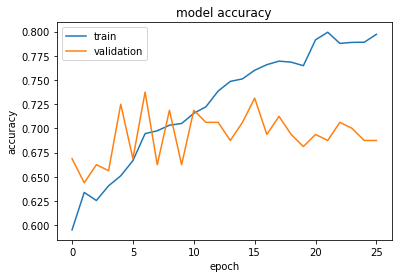

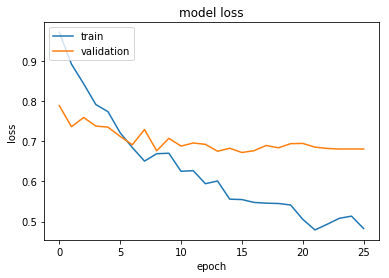

best_val_acc 0.7375
train_indices[:5] [0 1 2 3 4] train_indices[-5:] [805 806 807 808 809]
val_indices[:5] [13 22 24 26 35] val_indices[-5:] [785 789 792 793 799]

Train size:  648
Val size:  162
Train label distribution:  OrderedDict([(-1, 123), (0, 285), (1, 240)])
Val label distribution:  OrderedDict([(-1, 24), (0, 93), (1, 45)])
Found 648 images belonging to 3 classes.
Found 162 images belonging to 3 classes.

Epoch 1/3
62/62 [==============================] - 32s 509ms/step - loss: 2.1648 - acc: 0.4542 - f1: 0.4445 - recall: 0.4345 - precision: 0.4555 - val_loss: 0.8553 - val_acc: 0.6750 - val_f1: 0.6778 - val_recall: 0.6375 - val_precision: 0.7258
Epoch 2/3
62/62 [==============================] - 26s 415ms/step - loss: 1.2033 - acc: 0.5413 - f1: 0.5247 - recall: 0.5040 - precision: 0.5477 - val_loss: 0.8092 - val_acc: 0.6562 - val_f1: 0.6502 - val_recall: 0.6062 - val_precision: 0.7051
Epoch 3/3
62/62 [==============================] - 26s 412ms/step - loss: 1.0483 - acc: 0.5701

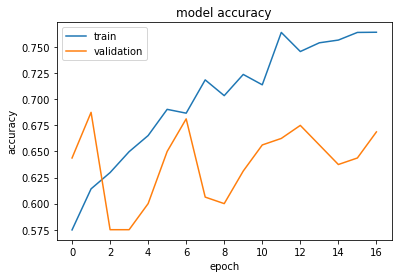

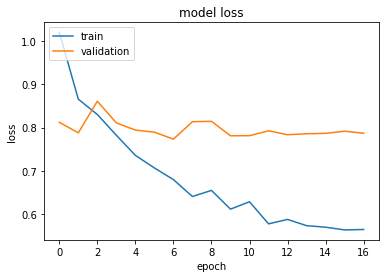

best_val_acc 0.6875
train_indices[:5] [0 1 3 5 6] train_indices[-5:] [804 805 806 808 809]
val_indices[:5] [ 2  4  8 15 16] val_indices[-5:] [778 781 796 800 807]

Train size:  649
Val size:  161
Train label distribution:  OrderedDict([(-1, 113), (0, 311), (1, 225)])
Val label distribution:  OrderedDict([(-1, 34), (0, 67), (1, 60)])
Found 649 images belonging to 3 classes.
Found 161 images belonging to 3 classes.

Epoch 1/3
62/62 [==============================] - 35s 561ms/step - loss: 2.4113 - acc: 0.4646 - f1: 0.4572 - recall: 0.4467 - precision: 0.4690 - val_loss: 1.1252 - val_acc: 0.5375 - val_f1: 0.5263 - val_recall: 0.5125 - val_precision: 0.5414
Epoch 2/3
62/62 [==============================] - 26s 427ms/step - loss: 1.2120 - acc: 0.5367 - f1: 0.5206 - recall: 0.5009 - precision: 0.5427 - val_loss: 0.8784 - val_acc: 0.5813 - val_f1: 0.5892 - val_recall: 0.5500 - val_precision: 0.6367
Epoch 3/3
62/62 [==============================] - 26s 416ms/step - loss: 0.9877 - acc: 0.5869

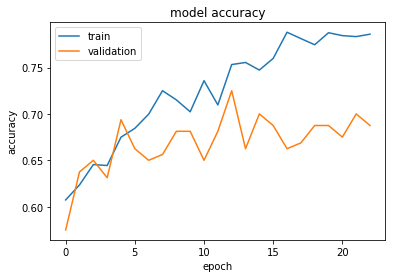

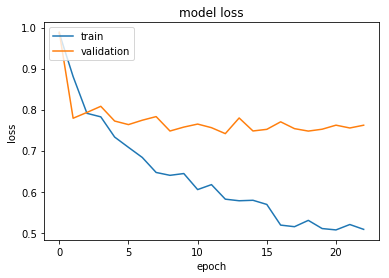

best_val_acc 0.725
train_indices[:5] [0 1 2 3 4] train_indices[-5:] [804 806 807 808 809]
val_indices[:5] [ 5  7 11 29 33] val_indices[-5:] [794 795 797 801 805]

Train size:  649
Val size:  161
Train label distribution:  OrderedDict([(-1, 127), (0, 302), (1, 220)])
Val label distribution:  OrderedDict([(-1, 20), (0, 76), (1, 65)])
Found 649 images belonging to 3 classes.
Found 161 images belonging to 3 classes.

Epoch 1/3
62/62 [==============================] - 37s 597ms/step - loss: 2.2092 - acc: 0.4502 - f1: 0.4465 - recall: 0.4371 - precision: 0.4567 - val_loss: 0.9764 - val_acc: 0.5375 - val_f1: 0.4991 - val_recall: 0.4625 - val_precision: 0.5444
Epoch 2/3
62/62 [==============================] - 26s 420ms/step - loss: 1.2308 - acc: 0.5438 - f1: 0.5303 - recall: 0.5080 - precision: 0.5559 - val_loss: 0.7381 - val_acc: 0.6562 - val_f1: 0.6235 - val_recall: 0.5750 - val_precision: 0.6838
Epoch 3/3
62/62 [==============================] - 26s 415ms/step - loss: 0.9872 - acc: 0.5936 

62/62 [==============================] - 26s 418ms/step - loss: 0.4941 - acc: 0.7960 - f1: 0.7868 - recall: 0.7509 - precision: 0.8280 - val_loss: 0.7698 - val_acc: 0.6500 - val_f1: 0.5905 - val_recall: 0.5250 - val_precision: 0.6805

Epoch 00026: ReduceLROnPlateau reducing learning rate to 4.0353603617404586e-05.
best_train_acc 0.7977296183168334
best_val_acc 0.6625
best_f1 0.6290748596191407
best_train_f1 0.7890982184370728


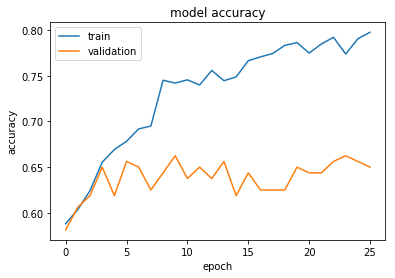

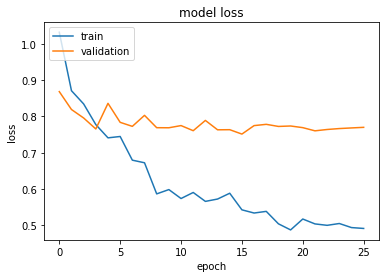

best_val_acc 0.6625
Cross-validation val accuracy results:  [0.68125, 0.7375, 0.6875, 0.725, 0.6625]
Cross-validation val accuracy results: 0.70% (+/- 0.03%)

 Cross-validation val f1 results:  [0.6420663714408874, 0.6807603359222412, 0.6428461134433746, 0.6740702867507935, 0.6290748596191407]
Cross-validation val f1 results: 0.65% (+/- 0.02%)
testDir dataset/test2/
Found 90 images belonging to 3 classes.
filenames from gen:  ['-1/Car accident 1.jpg', '-1/Dead bodies 3.jpg', '-1/Depressed pose 3.jpg', '-1/Dog 31.jpg', '-1/Frustrated pose 1.jpg', '-1/Frustrated pose 2.jpg', '-1/Funeral 1.jpg', '-1/Gun 9.jpg', '-1/Hangover 1.jpg', '-1/KKK rally 2.jpg', '-1/Miserable pose 5.jpg', '-1/Sad pose 3.jpg', '-1/Shot 4.jpg', '-1/Sidewalk 6.jpg', '-1/Soldiers 7.jpg', '-1/Tornado 3.jpg', '0/Alcohol 7.jpg', '0/BDSM 3.jpg', '0/Bird 5.jpg', '0/Bricks 1.jpg', '0/Camping 8.jpg', '0/Camping 9.jpg', '0/Child labor 1.jpg', '0/Crosswalk 1.jpg', '0/Cups 1.jpg', '0/Cups 4.jpg', '0/Doctor 3.jpg', '0/Fire hydra

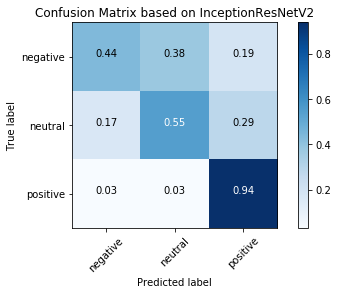

In [7]:
# Instantiate the cross validator
skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True) # 
cv_accuracies = []
cv_f1s = []
    
# X = input_x
# y = input_y


    
# Shuffe input data
X, y = shuffle(X,y)

def setup_to_finetune(model, useF1Score):
    """Freeze the bottom LAYERS_TO_FREEZE and retrain the remaining top layers.
  note: LAYERS_TO_FREEZE corresponds to the top 2 inception blocks in the inceptionv3 arch
  Args:
    model: keras model
    """    
    totalLayers = len(model.layers)
    lastFreezeLayer = totalLayers - LAYERS_TO_UNFREEZE
    print("LAYERS_TO_UNFREEZE:", LAYERS_TO_UNFREEZE, "last layer id to freeze", lastFreezeLayer, "total layers, ",totalLayers)
    for layer in model.layers[:lastFreezeLayer]:
        layer.trainable = False
    for layer in model.layers[lastFreezeLayer:]:
        layer.trainable = True
    #optimizers.SGD(lr=0.0001, momentum=0.9)
    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy',\
                  metrics=imut.get_metrics(useF1Score))

def setup_to_transfer_learn(model, base_model, useF1Score):
    """Freeze all layers and compile the model"""    
    for layer in base_model.layers:
        layer.trainable = False
       
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', \
                  metrics=imut.get_metrics(useF1Score))
    print()

def add_new_last_layer(base_model, nb_classes):
    """Add last layer to the convnet
      Args:
        base_model: keras model excluding top
        nb_classes: # of classes
      Returns:
        new keras model with last layer
    """
    # 62,65,67% w/o reducing lr
    x = base_model.output
    x = Dropout(0.5)(x)
    # convert MxNxC into 1xC
    #x = GlobalAveragePooling2D()(x)
    x = GlobalMaxPooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(FC_SIZE, activation='relu')(x) #new FC layer, random init
    x = Dropout(0.5)(x)
    output_layer = Dense(nb_classes, activation='softmax')(x) #new softmax layer
    model = Model(input=base_model.input, output=output_layer)
    #print(model.summary())
    
#     x = base_model.output
#     x = Flatten()(x)
#     x = Dropout(0.5)(x)
#     output_layer = Dense(nb_classes, activation='softmax', name='softmax')(x)
#     model = Model(inputs=base_model.input, outputs=output_layer)
    return model




def train(trainDir, valDir, config, class_weights): 
    """Use transfer learning and fine-tuning to train a network on a new dataset"""     
    
    nb_classes = len(glob.glob(trainDir + "/*"))
    
    # this is a generator that will read pictures found in
    # subfolers of 'data/train', and indefinitely generate
    # batches of augmented image data
    isForTrain = True
    train_batches = imut.get_data_generator(trainDir, config, isForTrain)  
    

    # this is a similar generator, for validation data
    isForTrain = False
    validation_batches = imut.get_data_generator(valDir, config, isForTrain)  
        
    # setup model
    base_model = ResNet152(include_top=False, weights='imagenet')
    model = add_new_last_layer(base_model, nb_classes)

    # transfer learning
    setup_to_transfer_learn(model, base_model, config['useF1Score'])
    
    # monitor='val_loss', patience = 5 default
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.7, 
                                  patience=2,
                                  min_delta=0.0001,
                                  cooldown=1,
                                  min_lr=1e-7,
                                  verbose=verbose)
    # monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
    
    filepath = model_results_root_dir + "image.weights.best.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience)    
    callbacks_list = [ early_stopping, reduce_lr]  # , checkpoint

    # train the model on the new data for a few epochs
    history = model.fit_generator(
            train_batches,
            steps_per_epoch= 2000 // config['batch_size'], # train_batches.samples
            epochs=3, 
            validation_data=validation_batches,
            validation_steps= validation_batches.samples // config['batch_size'], 
            shuffle=True,
            verbose=config['verbose']
            #callbacks=callbacks_list,
            ) # class_weight=class_weights'auto'
    
    # fine-tuning
    print("Starting fune-tuning")
    setup_to_finetune(model, config['useF1Score'])
    
    # Add checkpointing to save best model
    #callbacks_list.append(checkpoint)
    history = model.fit_generator(
            train_batches,
            steps_per_epoch=  2000 // config['batch_size'], # train_batches.samples
            epochs=config['nb_epochs'],
            validation_data=validation_batches,
            validation_steps= validation_batches.samples // config['batch_size'],
            shuffle=True,
            verbose=config['verbose'],
            callbacks=callbacks_list
            ) # 'auto' class_weight=class_weights
    return history, model




def evalaute_on_test_data(model, config):
    testDir = test_images_src
    print("testDir", testDir)
    isForTrain = False
    config['batch_size'] = 1
    
    # Divide input images into train and dev set, and each one into {negative, neutral, positive}
    isForTest = True
    dt.create_dataset("test", testDir, test_images_classified, test_x, test_y, isForTest)
    test_batches = imut.get_data_generator_for_test(test_images_classified, config) 
    print("filenames from gen: ", test_batches.filenames, "\n")
    results = model.evaluate_generator(test_batches, steps=test_batches.samples // config['batch_size'], verbose=1)
    print(model.metrics_names, results)
    
    predictions = model.predict_generator(test_batches, steps=test_batches.samples // config['batch_size'], verbose=1)
    print("predictions\n", predictions)
    print("\n")
    intLabel_to_index = (imut.get_label_map_from_train_generator(input_images_classified, config))
    print("label_map_from_train_gen :", intLabel_to_index,"\n")
    #intLabel_to_index = imut.convert_class_to_index_into_int(label_map_from_train_gen)
    print("intLabel_to_index", intLabel_to_index)
    predictions = imut.conver_predictions_to_classes(predictions, intLabel_to_index)
    print("predictions", predictions)
    test_filenames = test_batches.filenames
    print("test_filenames",test_filenames)
    print("imageNameToLabel", imageNameToLabel)
    y_true = imut.get_truth_labels_test_data(test_filenames, imageNameToLabel)
    print("y_true", y_true)
    y_pred = predictions

    cnf_matrix = confusion_matrix(y_true, y_pred)
    print("cnf_matrix", cnf_matrix)
    titleOfConfusionMatrix = "Confusion Matrix based on InceptionResNetV2"
    pt.plot_confusion_matrix_from_labels(y_true, y_pred, titleOfConfusionMatrix)
    

def prepare_and_train(config):
    bestModel = None
    final_model_val_acc = -1
    for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
        print("train_indices[:5]", train_indices[:5],"train_indices[-5:]",train_indices[-5:])
        print("val_indices[:5]", val_indices[:5],"val_indices[-5:]",val_indices[-5:])
        print()
        print("Train size: ", len(train_indices))
        print("Val size: ", len(val_indices))

        X_train, X_val = X[train_indices], X[val_indices]
        y_train, y_val = y[train_indices], y[val_indices]
        
        print("Train label distribution: ", pt.get_label_count(y_train))
        print("Val label distribution: ", pt.get_label_count(y_val))
        
        class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
        #print("\nclass_weights", class_weights)
        
        # Divide input images into train and dev set, and each one into {negative, neutral, positive}
        isForTest = False
        dt.create_dataset("train", input_images_src, input_images_classified, X_train, y_train, isForTest)
        dt.create_dataset("val", input_images_src, input_images_classified, X_val, y_val, isForTest)

        trainDir = input_images_classified + "/" + "train" + "/"
        valDir = input_images_classified + "/" + "val" + "/"

        history, model = train(trainDir, valDir, config, class_weights)
        
        pt.plot_model_accuracy(history, model_results_root_dir, useF1Score)
        best_val_acc = max(history.history['val_acc'])
        
        if best_val_acc > final_model_val_acc:
            bestModel = model
            final_model_val_acc = best_val_acc
        
        cv_accuracies.append(best_val_acc)
        print("best_val_acc", best_val_acc)
        if useF1Score:
            best_val_f1 = max(history.history['val_f1'])
            cv_f1s.append(best_val_f1)

    print("=========================================")
    print("Cross-validation val accuracy results: " , cv_accuracies)
    print("Cross-validation val accuracy results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_accuracies), np.std(cv_accuracies)))

    if useF1Score:
        print("\n","Cross-validation val f1 results: " , cv_f1s)
        print("Cross-validation val f1 results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_f1s), np.std(cv_f1s)))   
    
    # Evaluate Test data set
    evalaute_on_test_data(model, config)
    
    bestModel.save(model_results_root_dir + "/bestmodel-" + str(final_model_val_acc) + ".h5")


def get_config():
    conf = {}
    conf["img_height"] = img_height
    conf["img_width"] = img_width
    conf["kfold_splits"] = kfold_splits
    conf["batch_size"] = batch_size
    conf["nb_epochs"] = nb_epochs
    conf['useF1Score'] = useF1Score
    conf['verbose'] = verbose
    return conf    
    
def main():
    config = get_config()
    print("config:\n", config)
    prepare_and_train(config)
    # predict()
    # text_pre_processing("hello&nbsp;hi")
    pass

if __name__ == "__main__":
    # execute only if run as a script
    main()




In [8]:
print("FC_SIZE", FC_SIZE)

FC_SIZE 1024
